In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [36]:
df_review = pd.read_csv("IMDB Dataset.csv")
df_review

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [37]:
df_positive = df_review[df_review['sentiment']=='positive'][:9000]
df_negative = df_review[df_review['sentiment']=='negative'][:1000]

df_review_imb = pd.concat([df_positive,df_negative ])

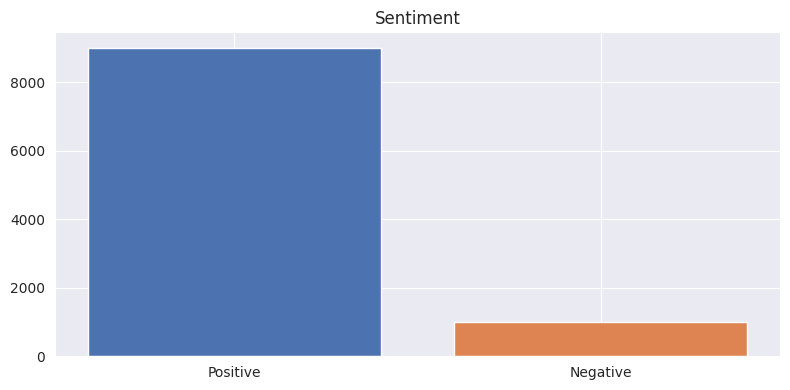

In [56]:
colors = sns.color_palette('deep')

plt.figure(figsize=(8,4), tight_layout=True)
plt.bar(x=['Positive', 'Negative'],
        height=df_review_imb.value_counts(['sentiment']),
        color=colors[:2])
plt.title('Sentiment')
plt.show()

In [39]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state= 0)
df_review_bal,df_review_bal['sentiment']=rus.fit_resample(df_review_imb[['review']],df_review_imb['sentiment'])
df_review_bal

,review,sentiment
0,Basically there's a family where a little boy ...,negative
1,"This show was an amazing, fresh & innovative i...",negative
2,Encouraged by the positive comments about this...,negative
3,Phil the Alien is one of those quirky films wh...,negative
4,I saw this movie when I was about 12 when it c...,negative
...,...,...
1995,Knute Rockne led an extraordinary life and his...,positive
1996,At the height of the 'Celebrity Big Brother' r...,positive
1997,This is another of Robert Altman's underrated ...,positive
1998,This movie won a special award at Cannes for i...,positive


In [40]:
print(df_review_imb.value_counts('sentiment'))
print(df_review_bal.value_counts('sentiment'))

sentiment
positive    9000
negative    1000
Name: count, dtype: int64
sentiment
negative    1000
positive    1000
Name: count, dtype: int64


In [41]:
from sklearn.model_selection import train_test_split

train,test = train_test_split(df_review_bal,test_size =0.33,random_state=42)

In [42]:
train_x, train_y = train['review'], train['sentiment']
test_x, test_y = test['review'], test['sentiment']

In [43]:
train_y.value_counts()

sentiment
negative    675
positive    665
Name: count, dtype: int64

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
train_x_vector = tfidf.fit_transform(train_x)
# also fit the test_x_vector
test_x_vector = tfidf.transform(test_x)
sparse_df = pd.DataFrame.sparse.from_spmatrix(train_x_vector, index=train_x.index, columns=feature_names)

In [45]:
from sklearn.svm import SVC
svc = SVC(kernel='linear')
svc.fit(train_x_vector, train_y)

SVC(kernel='linear')

In [46]:
print(svc.predict(tfidf.transform(['A good movie'])))
print(svc.predict(tfidf.transform(['An excellent movie'])))
print(svc.predict(tfidf.transform(['I did not like this movie at all I gave this movie away'])))

['positive']
['positive']
['negative']


#DECISION TREE

In [47]:
from sklearn.tree import DecisionTreeClassifier
dec_tree = DecisionTreeClassifier()
dec_tree.fit(train_x_vector, train_y)

DecisionTreeClassifier()

#NAIVE BAYES

In [48]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(train_x_vector.toarray(), train_y)

GaussianNB()

#LOGISTIC REGRESSION

In [49]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(train_x_vector,train_y)

LogisticRegression()

#MEAN ACCURACY

In [50]:
print(svc.score(test_x_vector, test_y))
print(dec_tree.score(test_x_vector, test_y))
print(gnb.score(test_x_vector.toarray(), test_y))
print(log_reg.score(test_x_vector, test_y))

0.8409090909090909
0.6545454545454545
0.6348484848484849
0.8303030303030303


#F1 SCORE

In [51]:
from sklearn.metrics import f1_score
f1_score(test_y,svc.predict(test_x_vector),
          labels = ['positive','negative'],average=None)

array([0.84671533, 0.83464567])

#CLASSIFICATION REPORT

In [52]:
from sklearn.metrics import classification_report
print(classification_report(test_y,
                            svc.predict(test_x_vector),
                            labels = ['positive','negative']))

              precision    recall  f1-score   support

    positive       0.83      0.87      0.85       335
    negative       0.85      0.82      0.83       325

    accuracy                           0.84       660
   macro avg       0.84      0.84      0.84       660
weighted avg       0.84      0.84      0.84       660



#CONFUSION MATRIX

In [53]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(test_y,
                           svc.predict(test_x_vector),
                           labels = ['positive', 'negative'])
conf_mat

array([[290,  45],
       [ 60, 265]])

#TUNING THE MODEL

In [54]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y_encoded = le.fit_transform(train_y)
test_y_encoded = le.fit_transform(test_y)

In [55]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_clf.fit(train_x_vector, train_y_encoded)

xgb_pred = xgb_clf.predict(test_x_vector)

xgb_accuracy = accuracy_score(test_y_encoded, xgb_pred)*100
print(f"XGBoost Accuracy: {xgb_accuracy}")

xgb_f1_score = f1_score(test_y_encoded, xgb_pred, labels=['1', '0'], average=None)
print(f"XGBoost F1 Score: {xgb_f1_score}")

xgb_classification_report = classification_report(test_y_encoded, xgb_pred, labels=['1', '0'])
print(f"XGBoost Classification Report:\n{xgb_classification_report}")

XGBoost Accuracy: 76.81818181818181
XGBoost F1 Score: [0.76712329 0.76923077]
XGBoost Classification Report:
              precision    recall  f1-score   support

           1       0.78      0.75      0.77       335
           0       0.75      0.78      0.77       325

   micro avg       0.77      0.77      0.77       660
   macro avg       0.77      0.77      0.77       660
weighted avg       0.77      0.77      0.77       660

